# Hyperbolic Secant Distribution with Gaussian Process prior
+ Here, we consider a regression model $p(y|x,w) = HSD(y|f(x), s) = \frac{\sqrt{s}}{2\pi} 1/\cosh(\frac{\sqrt{s}}{2}(y - f(x)))$.
    + where, $s$ is fixed value and not infered.
+ A distribution of $f(x)$ is assumed a gaussian process prior
+ To infer the condition, we used a local variational approximation to approximate the Bayesian posterior distribution.

In [1]:
%matplotlib inline

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import hypsecant, cauchy, t
from scipy.spatial import distance_matrix

In [3]:
### problem condition
n = 100
N = 100
data_seed = 20191124
X_domain = (-10, 10)
M = 1
true_func = lambda x: (x * np.sin(x)).sum(axis = 1)

In [4]:
### data generation
np.random.seed(data_seed)
train_X = np.random.uniform(low = X_domain[0], high = X_domain[1], size = (n, M))
train_func = true_func(train_X)
# train_Y = train_func + hypsecant.rvs(size = n)
train_Y = train_func + cauchy.rvs(size = n)
# train_Y = train_func + t.rvs(df = 0.7, size = n)

test_X = np.random.uniform(low = X_domain[0], high = X_domain[1], size = (N, M))
test_func = true_func(test_X)
# test_Y = test_func + hypsecant.rvs(size = N)
test_Y = test_func + cauchy.rvs(size = N)
# test_Y = test_func + t.rvs(df = 0.7, size = N)

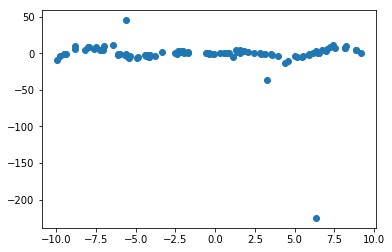

In [7]:
plt.scatter(train_X[:,0], train_Y)
plt.show()

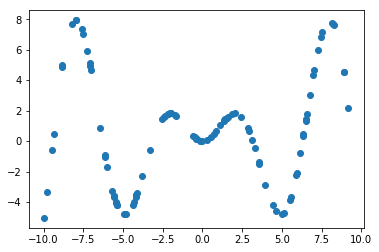

In [6]:
plt.scatter(train_X[:,0], train_func)
plt.show()

In [8]:
### learning setting
learning_seed = 20181121
iteration = 1000

theta1 = 1; theta2 = 1; theta3 = 0.00001
ln_sigma = 1

kronecker_delta = lambda x,y: np.exp(-distance_matrix(x,y)**2/0.000001)
used_kernel = lambda x, y: theta1 * np.exp(-distance_matrix(x, y)**2/theta2) + theta3 * kronecker_delta(x,y)
# used_kernel = lambda x, y: theta1 * np.exp(-distance_matrix(x, y, p=1)/theta2) + theta3 * kronecker_delta(x,y)

In [9]:
### initial learning
train_train_kernel = used_kernel(train_X, train_X)
inv_train_train_kernel = np.linalg.inv(train_train_kernel)

est_h_xi = np.abs(np.random.normal(size = n))
est_v_xi = -np.tanh(np.sqrt(est_h_xi)/2)/(np.sqrt(est_h_xi)/4)

In [10]:
F_trace = list()
for ite in range(iteration):
    est_inv_Sigma = -2*ln_sigma*np.diag(est_v_xi) + inv_train_train_kernel
    est_Sigma = np.linalg.inv(est_inv_Sigma)
    est_u = est_Sigma @ (ln_sigma * -2*est_v_xi * train_Y)
    
    est_h_xi = ln_sigma * ((train_Y - est_u)**2 + np.diag(est_Sigma))
    est_v_xi = -np.tanh(np.sqrt(est_h_xi)/2)/(np.sqrt(est_h_xi)/4)
    
    F = np.log(np.sqrt(est_h_xi)/2).sum() + est_v_xi @ est_h_xi
    F += np.linalg.slogdet(train_train_kernel)[1] + np.linalg.slogdet(est_inv_Sigma)[1]
    F += - ln_sigma * train_Y.T @ np.diag(est_v_xi) @ train_Y + est_u.T @ est_inv_Sigma @ est_u/2
    F_trace.append(F)


In [11]:
F_trace

[18413.39021373345,
 5054.843977470169,
 5276.1440829227295,
 5257.342486029169,
 5243.333237396595,
 5237.154106583188,
 5234.60203142939,
 5233.559358636173,
 5233.132235619005,
 5232.956192305452,
 5232.88319174498,
 5232.852771098755,
 5232.840048251321,
 5232.834713643322,
 5232.832473037828,
 5232.831530867825,
 5232.831134390286,
 5232.8309674643915,
 5232.830897162539,
 5232.830867544083,
 5232.83085506688,
 5232.830849809767,
 5232.83084759986,
 5232.8308466669205,
 5232.830846272069,
 5232.830846106776,
 5232.830846038043,
 5232.830846009382,
 5232.83084599874,
 5232.830845993789,
 5232.83084599221,
 5232.830845990857,
 5232.830845992176,
 5232.830845989687,
 5232.830845992223,
 5232.830845991079,
 5232.830845989873,
 5232.830845988108,
 5232.830845990748,
 5232.830845989318,
 5232.830845989426,
 5232.830845986288,
 5232.830845988386,
 5232.830845989565,
 5232.830845986472,
 5232.830845991512,
 5232.830845988834,
 5232.830845988785,
 5232.830845989566,
 5232.830845991822,
 52

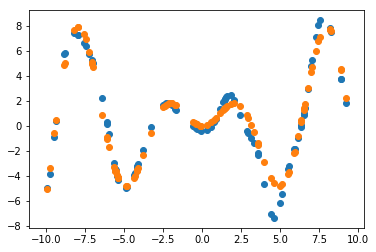

In [12]:
plt.scatter(train_X, est_u)
plt.scatter(train_X, train_func)
plt.show()

In [13]:
### predict the function
test_train_kernel = used_kernel(test_X, train_X)
est_f_mean = test_train_kernel @ inv_train_train_kernel @ est_u

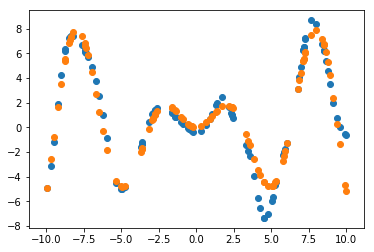

In [14]:
plt.scatter(test_X, est_f_mean)
plt.scatter(test_X, test_func)
plt.show()